<a href="https://colab.research.google.com/github/zualexander/mai-aiapp-computer-vision/blob/main/mai_computer_vision_experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import (SGD, RMSprop)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras import models
from tensorflow.keras.models import Model
import tarfile
import os
import splitfolders
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

#variables

In [40]:
batch_size = 32
epochs = 20
img_size = 256
train_data_path = '/tmp/dataset/output/train/'
val_data_path = '/tmp/dataset/output/val/'
input_img = Input(shape=(img_size, img_size, 3))

#Functions

In [4]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def plot_accuracy_and_loss(history):

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Download Dataset
from [howto](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e)

In [5]:
!wget --no-check-certificate \
    ""http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"" \
    -O "/tmp/dataset.tar.gz"

--2022-06-01 15:54:41--  http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz
Resolving aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)... 132.230.105.132
Connecting to aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)|132.230.105.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541562880 (516M) [application/x-gzip]
Saving to: ‘/tmp/dataset.tar.gz’

/tmp/dataset.tar.gz 100%[===================>] 516.47M  25.4MB/s    in 22s     

2022-06-01 15:55:04 (23.8 MB/s) - ‘/tmp/dataset.tar.gz’ saved [541562880/541562880]



In [6]:
!mkdir /tmp/dataset 
!tar xf /tmp/dataset.tar.gz --directory=/tmp/dataset

# Datasplit

In [7]:
splitfolders.ratio("/tmp/dataset/images", output="/tmp/dataset/output",
    seed=1337, ratio=(.75, .25), group_prefix=None, move=False)

Copying files: 4947 files [00:01, 3428.30 files/s]


In [ ]:
ls /tmp/dataset/output/train

BEANS/   CHIPS/      FISH/   JUICE/  PASTA/   SUGAR/         WATER/
CAKE/    CHOCOLATE/  FLOUR/  MILK/   RICE/    TEA/
CANDY/   COFFEE/     HONEY/  NUTS/   SODA/    TOMATO_SAUCE/
CEREAL/  CORN/       JAM/    OIL/    SPICES/  VINEGAR/


In [8]:
train = keras.utils.image_dataset_from_directory(
    directory=train_data_path,
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=(img_size, img_size))

validation = keras.utils.image_dataset_from_directory(
    directory=val_data_path,
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=(img_size, img_size))


Found 3699 files belonging to 25 classes.
Found 1248 files belonging to 25 classes.


In [9]:
classes=train.class_names
print(len(classes))

25


## data generator

In [10]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(                      
    rotation_range=90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.2
    )

In [11]:
val_datagen = keras.preprocessing.image.ImageDataGenerator()

In [12]:
train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 3699 images belonging to 25 classes.


In [13]:
val_generator = val_datagen.flow_from_directory(val_data_path,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 1248 images belonging to 25 classes.


#ResNet Model

In [14]:
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=input_img,
    input_shape=(img_size, img_size, 3),
    pooling=None,
    classes=len(classes)
) 

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

In [ ]:
plot_model(resnet_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
resnet_model.count_params()

23587712

#Inception Model

In [15]:
nClasses = len(classes)
print (nClasses)

25


Get conv_block4_out index from ResNet50

In [51]:
ind = 0
for layer in resnet_model.layers[:-1]:
  if layer.name == 'conv3_block4_out':
    break
  ind += 1

Create inception layer:

In [60]:
x = resnet_model.layers[ind].output

layer_1 = Conv2D(256, (1,1), padding='same', activation='relu')(x)
layer_2 = Conv2D(128, (3,3), padding='same', activation='relu')(x)
layer_3 = Conv2D(32, (5,5), padding='same', activation='relu')(x)
layer_pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)


mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3, layer_pool], axis = -1)

Add dense layers and prediction head:

In [61]:
flat_1 = Flatten()(mid_1)

dense_1 = Dense(128, activation='relu')(flat_1)
dense_2 = Dense(32, activation='relu')(dense_1)
output = Dense(nClasses, activation='softmax')(dense_2)

In [62]:
#model_inception = Model(inputs=input_img, outputs=output)
model_inception = Model(inputs=resnet_model.layers[0].input, outputs=output)

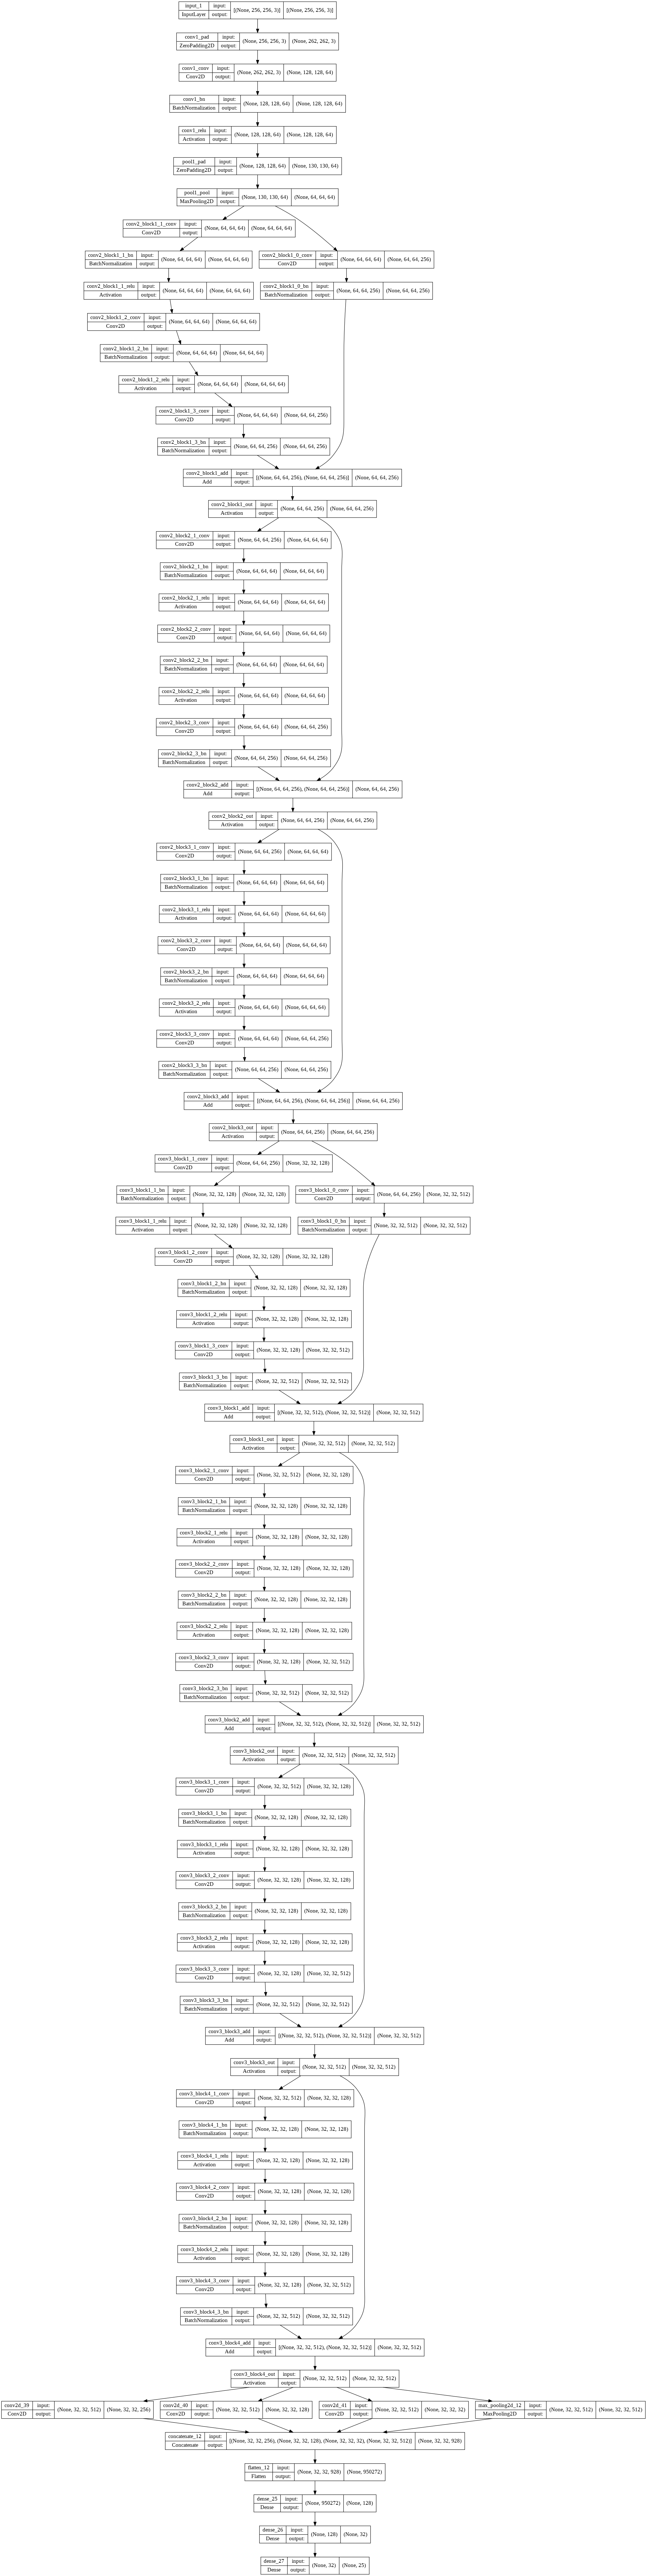

In [73]:
plot_model(model_inception, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_inception.summary()

Freeze conv2 and before

In [64]:
for layer in model_inception.layers[:-1]:
  if(layer.name.startswith('conv2')):
    break;
  layer.trainable = False


In [29]:
model_inception.count_params()

489148025

##Compile model

In [65]:
model_inception.compile(
  optimizer=keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

##Train model

In [66]:
hist = model_inception.fit(train_generator, validation_data=val_generator, epochs=epochs)

Epoch 1/20
116/116 [==============================] - 81s 673ms/step - loss: 15.6291 - acc: 0.0543 - val_loss: 3.2095 - val_acc: 0.0745
Epoch 2/20
116/116 [==============================] - 77s 660ms/step - loss: 3.2045 - acc: 0.0741 - val_loss: 3.1996 - val_acc: 0.0745
Epoch 3/20
116/116 [==============================] - 76s 658ms/step - loss: 3.1952 - acc: 0.0754 - val_loss: 3.1912 - val_acc: 0.0745
Epoch 4/20
116/116 [==============================] - 76s 658ms/step - loss: 3.1873 - acc: 0.0754 - val_loss: 3.1841 - val_acc: 0.0745
Epoch 5/20
116/116 [==============================] - 76s 658ms/step - loss: 3.1807 - acc: 0.0754 - val_loss: 3.1783 - val_acc: 0.0745
Epoch 6/20
116/116 [==============================] - 77s 660ms/step - loss: 3.1753 - acc: 0.0754 - val_loss: 3.1736 - val_acc: 0.0745
Epoch 7/20
116/116 [==============================] - 78s 667ms/step - loss: 3.1709 - acc: 0.0754 - val_loss: 3.1698 - val_acc: 0.0745
Epoch 8/20
116/116 [==============================] - 

#Model evaluation

##training history

In [67]:
print ("test accuracy ", hist.history['acc'][-1])

test accuracy  0.07542578876018524


#validation history

In [68]:
print ("validation accuracy ", hist.history['val_acc'][-1])

validation accuracy  0.07451923191547394


#accuracy and loss plot

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


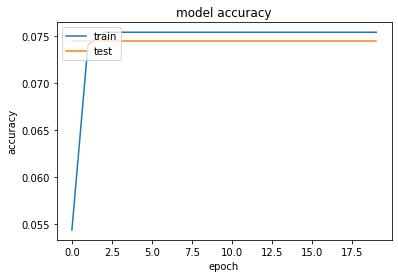

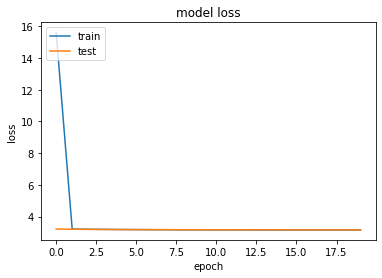

In [69]:
print(hist.history.keys())
plot_accuracy_and_loss(hist)

#Confusion matrix

In [70]:
Y_pred = model_inception.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
con_mat = confusion_matrix(val_generator.classes, y_pred)
print('Confusion Matrix')
print(con_mat)
print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=classes))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Confusion Matrix
[[ 0  0 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 93  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 70  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 77  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 47  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 61  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0 76  0  0  0  0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## plot

In [71]:
sns.set_theme(style='darkgrid')

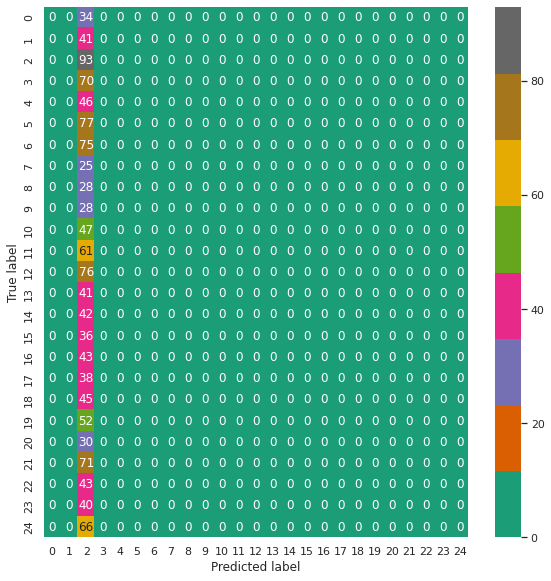

In [72]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Dark2)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()